## Gene modules comparisons

### Weighted Gene Correlation Network Analysis (WGCNA)
Some more details can be found in our work [1], briefly:

*To obtain modules of coexpressed genes across developmental stages and adult tissues, we used WGCNA . We selected 17 amphioxus and 27 zebrafish samples, including replicates of adult tissues when possible. Of 20,569 amphioxus and 20,082 zebrafish genes that had an ortholog in at least one other species used for gene family construction, 16,421 and 18,285 genes, respectively, had enough variance (CV ≥ 1), to be considered for further analysis. WGCNA was run with default parameters (softPower settings 9 in amphioxus and 7 in zebrafish; with unsigned networks), resulting in 25 and 23 modules in amphioxus and zebrafish, respectively. Genes in each cluster were assigned positive or negative correlation status. Each cluster was assigned a tissue affinity and/or functional category based on its overall gene expression and GO enrichment profiles (Supplementary File 1). Next, to assess the statistical significance of homolog overlap between each pair of clusters from each species, we counted the number of overlapping homologous groups (i.e. paralogs within a gene family were not counted multiple times), and performed a hypergeometric test taking as background only the number of homologous groups with members in both amphioxus and zebrafish.*

---
1. Marlétaz, F., Firbas, P. N., Maeso, I., Tena, J. J., Bogdanovic, O., Perry, M., … Irimia, M. (2018). Amphioxus functional genomics and the origins of vertebrate gene regulation. Nature, 564(7734), 64–70. https://doi.org/10.1038/s41586-018-0734-6
2. Langfelder, P. & Horvath, S. WGCNA: an R package for weighted correlation network analysis. BMC Bioinformatics 9, 559 (2008).

## What we will do

* ### Assignment of genes to modules (WGCNA / MFUZZ)    

We use WGCNA to cluster genes by their RNA activity in various TRNAseq experiments, both in developmental stages and pure tissue samples. This analysis assigns each gene in a single cluster. These clusters have names like "blue". "green" etc.We manually explore the clusters, and by determining at which experiment the genes of the cluster seem to be differentially expressed (but also by GO analysis on each cluster), we assign more meaningful names to the clusters , like "liver", "muscle" etc. The translating dictionaries are in this notebook.

* ### Grouping of genes into homology-families       
    
* ### Assignment of genome regions to genes 
We assign a BASAL region to each gene, it starts from its TSS and extends 5kb upstream and 1kb downstream,
or untill it encounters another TSS.
    
* ###  cis-regulatory level comparisons
We scan the genome for a large set of motifs (see relevant notebook) and extract the motifs that are found
inside each gene's basal region. By summing the counts in each module, we have counts of motifs per 
module. Now we can compair modules on cis-regulatory level


In [1]:
### translate the uninformative color names to manually made 
                  #informative names for each module
### Cleaner versions of these dictionaries at the 
                  #bottom of the notebook
transA = {'black' : '32 cells','blue' : 'N.tube(neurotrans.)',
          'brown' : 'Gills','cyan' : 'N.tube(neurogen.)',
          'darkmagenta' : 'Ovary/ Testis(translation)',
          'darkorange' : 'Cilium','darkred' : 'Muscle',
          'darkseagreen4' : '8-36hpf embryo/ Skin/ Cirri(memb. synt.)',
          'darkslateblue' : '8hpf embryo(transcription, spliceosome)',
          'darkturquoise' : '36hpf embryo',
          'green' : 'Eggs/ 32 cells(cell cycle)',
          'greenyellow' : 'Hepatic(lipid catabolism)',
          'lavenderblush3' : 'Cirri / PreMet. / Muscle - actomyosin',
          'lightpink4' : '15hpf embryo','magenta' : 'Skin',
          'navajowhite2' : 'Immune','palevioletred3' : 'Ovary/ Eggs',
          'pink' : 'Gut','plum1' : 'Gut/ Hepatic','plum2' : 'Proteasome',
          'red' : 'PreMet.larvae','salmon' : 'Cirri(memb. synt.)',
          'sienna3' : 'Hepatic','thistle2' : 'Gills/ PreMet larvae',
'turquoise' : 'Mitochondrion'}
transZ = {'bisque4' : "larvae 7d melanin",'black' : "Ovary/ Sperm",
          'blue' : "Brain",
          'brown' : "Cilium",
          'brown4' : "Liver(carboxi.met.)", #/ lipid trans
          'coral2' : "Mitochondrion",
          'darkgreen' : "Intestine",
          'darkgrey' : "RNA,ribosome,proteasome",
          'darkmagenta' : "Translation,ribosome,RNA bin.",
          'darkorange' : "Muscle",
          'darkred' : "Liver(oxi-red.proc.", #/ hemostasis)
          'darkseagreen4' : "12-26hpf embryo/ Skin",
          'darkslateblue' : "Immune",
          'green' : "Spliceosome",
          'honeydew1' : "12-26hpf embryo",
          'ivory' : "Eye",
          'lightcyan' : "Heart",'lightgreen' : "Pancreas/ Testis",
          'magenta' : "Gills",'pink' : "Skin",
    'salmon' : "20-26hpf embryo",'yellow4' : "Kidney",
'yellowgreen' : "Gills/ Skin"}

## Preprocessing:

In [2]:
# Here we load the mapping of genes to modules from csv
# into dictionaries:
dan_cl = pd.read_csv(
    "/home/ska/panos/Thesis_shallow/data/wgcna_results/wgcna_dre_modulekey.tab.gz", sep='\t')
dan_cl.columns = ['geneID','clusterID','updown']
dan_cl_d = dict(dan_cl[['geneID','clusterID']].to_records(index=False))
bla_cl = pd.read_csv(
    "/home/ska/panos/Thesis_shallow/data/wgcna_results/wgcna_bla_modulekey.tab.gz", sep='\t')
bla_cl.columns = ['geneID','clusterID','updown']
bla_cl_d = dict(bla_cl[['geneID','clusterID']].to_records(index=False))

In [3]:
buz = pd.DataFrame(bla_cl.clusterID.value_counts())
buz["alt name"] = [transA[x] for x in buz.index.values]

In [4]:
buz.head(3)

clusterID                    alt name
green             1672  Eggs/ 32 cells(cell cycle)
turquoise         1287               Mitochondrion
greenyellow       1273   Hepatic(lipid catabolism)

In [5]:
bla_cl.clusterID.value_counts().head()

green          1672
turquoise      1287
greenyellow    1273
darkmagenta    1168
blue           1105
Name: clusterID, dtype: int64

In [6]:
# we load the gene family bindings into a dictionary where 
# key = geneID
# value =  unique gene family number (some integer)
gfams = genefams
gfamsC = genefamsC

gfamsD = {}
for rowi, row in gfams.iterrows():
    for species in ['Bla','Dre']:
        thing = row[species]
        if thing ==thing:
            for gene in thing:
                gfamsD[gene] = int(rowi)

In [7]:
# fam_of maps all genes to their gene family ID
fam_of = {}
for rowi,row in gfams[['Bla']].dropna().iterrows():
    thing = row.Bla
    if thing ==thing:
        for gene in thing:
            fam_of[gene]= rowi
for rowi,row in gfams[['Dre']].dropna().iterrows():
    for gene in row.Dre:
        fam_of[gene]= rowi

In [8]:
# We compute the upper tail of the hypergeometric distribution
# (survival function) for each pair of modules as a metric of enrichment
fon = []
gimme_fams = lambda g: [fam_of.get(x) for x in g.geneID.tolist()]
# Population size:
gene_POP = len(gfams)
PVS = pd.DataFrame()
# for each module in zebra
for gn,g  in dan_cl.groupby('clusterID'):
    # for each module in amphioxus:
    for bgn,bg  in bla_cl.groupby('clusterID'):
        
        fams = set(gimme_fams(g))
        bfams = set(gimme_fams(bg))
        
        gene_SS = len(fams) # Sample Size
        gene_SIP = len(bfams) # Success in Population
        gene_SIS = len(bfams.intersection(fams)) # success in sample

        if gene_SIS>0:
            #statf is the survival function of the hypergeom. distribution            
            fish = statf(gene_SIS-1,  gene_POP,  gene_SS, gene_SIP)
            fon.append( (gene_SIS,  gene_SS, gene_SIP, 
                         gene_POP, transZ[gn], transA[bgn]) )
        else:
            fish =1 
            
        PVS.loc[transZ[gn], transA[bgn]] = fish
        
# the translating dictionaries are at the end of the notebook

In [9]:
fon = pd.DataFrame(fon)
fon.columns = ["common gene families (Success in Sample)", 
               "zebra families (Sample Size)",
               "amphi families (Success in Polulation)", 
               "Total Families (population)",
              "zebra cluster", "amphi cluster"]

## The gene-based heatmap

In [10]:
# we get the -log transformation of the pvalues, clip them to a workable range
mPVS = PVS.applymap(lambda x: -log(x,10) ).copy().clip(upper=25,lower=0)

# We will compute the clustering outselves in order to be able to re-use it,
# and to have better control
# we cluster by row and by column, based on euclidean distance 
# and complete method:
linkage_HG_rows = hc.linkage(
    sp.distance.squareform(
        PWD(  mPVS.values, metric='euclidean'),
        checks=False), method='complete')
linkage_HG_cols = hc.linkage(
    sp.distance.squareform(
        PWD(  mPVS.T.values, metric='euclidean'),
        checks=False), method='complete')

# Calculating the clustering like this, allows us to use the 
# same clustering later on

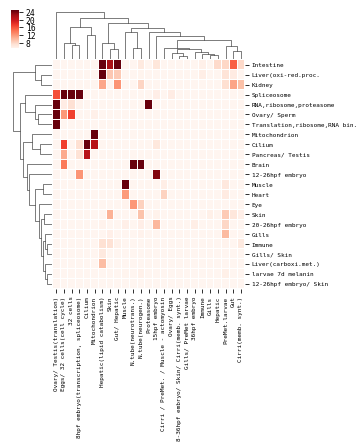

In [11]:
Fwidth = THESIS_PAGEWIDTH
Fheight = THESIS_PAGEWIDTH*1.2
ret = sns.clustermap( mPVS,
                      row_linkage = linkage_HG_rows,
                      col_linkage = linkage_HG_cols,
                      linewidths=0.01,
                      figsize =(12,12),
                      cmap='Reds',
                      vmax=25, vmin=5
                      )
ax = ret.ax_heatmap

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(6) 
for tick in ax.get_yticklabels():
    tick.set_rotation(0)
    tick.set_fontsize(6) 
    
fig = ret.fig

fig.subplots_adjust(left=.045, bottom=.35, right=.68, top=.98)

fig.set_size_inches (Fwidth, Fheight)
#>>> OUTPUT NAME
fig.savefig('../Figures/from_notebooks/tfigure_WGCNAHEAT.pdf')

## We now want to map PWMs to modules

To do this, we will use the BASAL region of genes:

In [12]:
# gene to "gene region" connection
# This dataframe connects each gene to a genomic region:
dan_greg = gr_basal['Dre']
dan_greg.columns = ['chrom','start','end','geneID','score','strand']
# dan_greg = dan_greg[['chrom','start','end','geneID','score','strand']]

bla_greg = gr_basal['Bla']
bla_greg.columns = ['chrom','start','end','geneID','score','strand']
# bla_greg = bla_greg[['chrom','start','end','geneID','score','strand']]

and of course the PWMs that have been mapped on ATACseq peaks already:

In [13]:
# load the PWM hits in a pybedtools object and sort
dan_motif_bed = BT(
    "/home/ska/panos/Thesis_shallow/data/PWM/danre_pwm_hits.bed.gz").sort()
bla_motif_bed = BT(
    "/home/ska/panos/Thesis_shallow/data/PWM/bralan_pwm_hits.bed.gz").sort()

amphi_stages = ['8','15','36','60','hep']
zebra_stages = ['dome','shield','80epi','8som','24h','48h']

We will now compute the LOJ intersection of the PMs to the BASAL regions,
For each gene this will give us all PWMs in its "regulatory landscape"

In [14]:
# Map the cluster ID to gene IDs:
dan_greg['cluster'] = dan_greg.geneID.map(dan_cl_d)
dan_greg = dan_greg[~dan_greg.cluster.isnull()]

bla_greg['cluster'] = bla_greg.geneID.map(bla_cl_d)
bla_greg = bla_greg[~bla_greg.cluster.isnull()]

# cast the gene region dataframes into pybedtools objects
# and intersect with motifs (with LEFT OUTER JOIN)
dan_loj = (BT()
  .from_dataframe(dan_greg[['chrom','start','end','cluster','score','strand']])
  .sort()
  .intersect(dan_motif_bed, loj=True, nonamecheck=True, sorted=True)
  ).to_dataframe()[['chrom','start','end','name','score','strand','blockCount']]

dan_loj = dan_loj[dan_loj.blockCount != '.']
dan_loj['fam'] = dan_loj.blockCount.map(SFDu)
dan_loj = dan_loj[~dan_loj['fam'].isnull()]
dan_loj.fam = dan_loj.fam.astype(int)

bla_loj = (BT()
  .from_dataframe(bla_greg[['chrom','start','end','cluster','score','strand']])
  .sort()
  .intersect(bla_motif_bed, loj=True, nonamecheck=True, sorted=True)
  ).to_dataframe()[['chrom','start','end','name','score','strand','blockCount']]

bla_loj = bla_loj[bla_loj.blockCount != '.']
bla_loj['fam'] = bla_loj.blockCount.map(SFDu)
bla_loj = bla_loj[~bla_loj['fam'].isnull()]
dan_loj.fam = dan_loj.fam.astype(int)
bla_loj.head()

# we had 
# gene_module --> genes
# genes --> genomic_regions
# motifs --> genomic_positions
# and we managed to connect them:
# module/cluster --> genes -> genomic regions --> motifs

chrom  start    end  name  score strand                  blockCount  \
1  Sc0000000  20509  26510  blue   6001      +         C2H2_ZF_Average_244   
5  Sc0000000  20509  26510  blue   6001      +  ARID_BRIGHT_RFX_M4343_1.02   
6  Sc0000000  20509  26510  blue   6001      +              RFX_Average_38   
7  Sc0000000  20509  26510  blue   6001      +            bZIP_Average_125   
8  Sc0000000  20509  26510  blue   6001      +          C2H2_ZF_M6539_1.02   

     fam  
1   11.0  
5    3.0  
6    3.0  
7  236.0  
8   21.0

In [15]:
# convert the left outer join dataframes into
# tables that contain a count per TF per stage:
bla_loC = [Counter(g.fam) for gn,g in bla_loj.groupby("name")]
bla_temp = pd.DataFrame(bla_loC)   
bla_temp = bla_temp.fillna(0)   
clustorder = [transA[gn] for gn,g in bla_loj.groupby("name")]

bla_temp.index = clustorder
bla_table = bla_temp.copy()

dan_loC = [Counter(g.fam) for gn,g in dan_loj.groupby("name")]
dan_temp = pd.DataFrame(dan_loC)   
dan_temp = dan_temp.fillna(0)   
clustorder = [transZ[gn] for gn,g in dan_loj.groupby("name")]

dan_temp.index = clustorder
dan_table = dan_temp.copy()
dan_table.iloc[:,:3].head()

0     1      2
larvae 7d melanin     223   537   14.0
Ovary/ Sperm          368  2109   52.0
Brain                1714  5518  129.0
Cilium                531  3008   61.0
Liver(carboxi.met.)    29   107    0.0

There might be some differences in the columns of the two tables, lets fix that:

In [16]:
# Get a list of the TFs that are found in both species:
dan_allfams = set(dan_table.columns)
bla_allfams = set(bla_table.columns)
allfams = sorted([ int(x) for x in dan_allfams
                  .intersection(bla_allfams)])

In [17]:
len(dan_allfams), len(bla_allfams),len(allfams)

(243, 242, 242)

## Normalization/Scaling

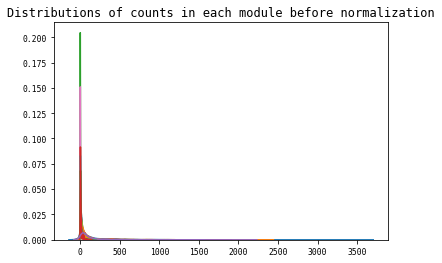

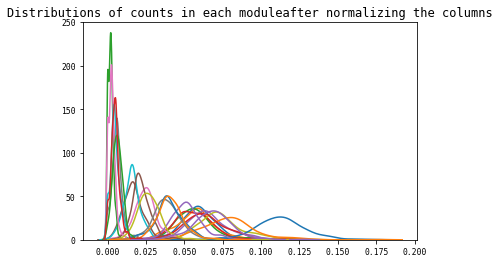

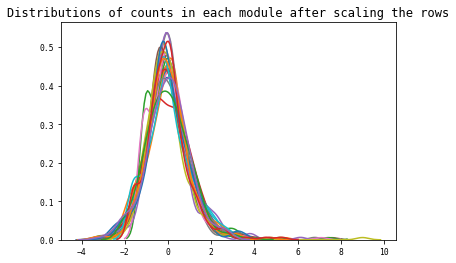

In [18]:
plt.figure()
for rowi,row in bla_table.iterrows():
    sns.kdeplot(row.values)
plt.title('Distributions of counts in each module before normalization')
plt.show()

# We divide each count with the sum for each TF,
# to normalize for TF promiscuity
bla_toplot = (bla_table
              .loc[:,allfams]/bla_table.loc[:,allfams].sum())

plt.figure()
for rowi,row in bla_toplot.iterrows():
    sns.kdeplot(row.values)
plt.title('Distributions of counts in each module\
after normalizing the columns')
plt.show()

# then scale the rows to normalize for module size
bla_toplot.loc[:,:] = scale(bla_toplot, axis=1)

plt.figure()
for rowi,row in bla_toplot.iterrows():
    sns.kdeplot(row.values)
plt.title('Distributions of counts in each module after scaling the rows')
plt.show()

dan_toplot =  (dan_table
               .loc[:,allfams]/dan_table.loc[:,allfams].sum())
dan_toplot.loc[:,:] = scale(dan_toplot, axis=1)      

We can now directly compare modules between the two species.     
We compute pairwise correlations next:

In [19]:
ouf = pd.DataFrame()

for dani,danrow in dan_toplot.iterrows():
    for blai,blarow in bla_toplot.iterrows():
        ouf.loc[dani,blai] = pearsonr(danrow.values, blarow.values)[0]

In [20]:
ouf.iloc[:3,:3]

32 cells  N.tube(neurotrans.)     Gills
larvae 7d melanin -0.151380             0.052799  0.086495
Ovary/ Sperm       0.062331            -0.057291 -0.042298
Brain             -0.054350             0.270706  0.114507

In [21]:
# Get euclidean distances for each pair of modules in a table:
dists =  pd.DataFrame( PWD(dan_toplot,bla_toplot, metric="correlation") )
dists.columns = bla_toplot.index
dists.index = dan_toplot.index

dists.iloc[:3,:3]

32 cells  N.tube(neurotrans.)     Gills
larvae 7d melanin  1.151380             0.947201  0.913505
Ovary/ Sperm       0.937669             1.057291  1.042298
Brain              1.054350             0.729294  0.885493

## The final plot:

We can now directly visualize the table with the correlations.    
We will use the clustering we got for the gene-based table earlier:

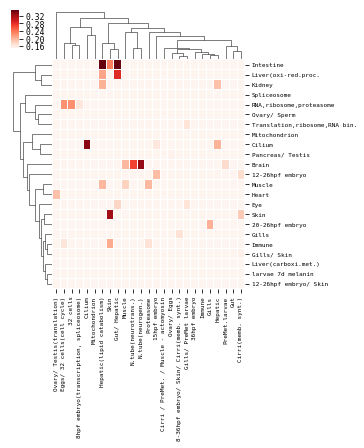

In [22]:
# we can now visualize the TF-based distances
# we'll use the clustering from the gene-based comparison


Fwidth = THESIS_PAGEWIDTH
Fheight = THESIS_PAGEWIDTH*1.2
# fig, axx = plt.subplots()


ret = sns.clustermap( 1-dists, 
                    
                    # The previously computed clustering
                    row_linkage=linkage_HG_rows, 
                    col_linkage=linkage_HG_cols,
                    
                    linewidths=0.01,
                    figsize =(12,12),
                    
                    vmax=0.35,
                    vmin=0.15,
                    cmap = 'Reds'
                   )

ax = ret.ax_heatmap

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(6) 
for tick in ax.get_yticklabels():
    tick.set_rotation(0)
    tick.set_fontsize(6) 
    
fig = ret.fig
fig.subplots_adjust(left=.045, bottom=.35, right=.68, top=.98)
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_WGCNAHEAT2.pdf')

### PWM z-scores plots

In [23]:
def RBOscore(l1, l2, p = 0.98):
    # https://github.com/ragrawal/measures/blob/master/measures/rankedlist/RBO.py

    """
        Calculates Ranked Biased Overlap (RBO) score. 
        l1 -- Ranked List 1
        l2 -- Ranked List 2
    """
#     if l1 == None: l1 = []
#     if l2 == None: l2 = []
    
    sl,ll = sorted([(len(l1), l1),(len(l2),l2)], key=lambda x: x[0])
    s, S = sl
    l, L = ll
    if s == 0: return 0

    # Calculate the overlaps at ranks 1 through l 
    # (the longer of the two lists)
    ss = set([]) # contains elements from the smaller list till depth i
    ls = set([]) # contains elements from the longer list till depth i
    x_d = {0: 0}
    sum1 = 0.0
    for i in range(l):
        x = L[i]
        y = S[i] if i < s else None
        d = i + 1
        
        # if two elements are same then 
        # we don't need to add to either of the set
        if x == y: 
            x_d[d] = x_d[d-1] + 1.0
        # else add items to respective list
        # and calculate overlap
        else: 
            ls.add(x) 
            if y != None: ss.add(y)
            x_d[d] = x_d[d-1] + (1.0 if x in ss else 0.0) + (1.0 if y in ls else 0.0)     
        #calculate average overlap
        sum1 += x_d[d]/d * pow(p, d)
        
    sum2 = 0.0
    for i in range(l-s):
        d = s+i+1
        sum2 += x_d[d]*(d-s)/(d*s)*pow(p,d)

    sum3 = ((x_d[l]-x_d[s])/l+x_d[s]/s)*pow(p,l)

    # Equation 32
    rbo_ext = (1-p)/p*(sum1+sum2)+sum3
    return rbo_ext

In [24]:
superfams_['u'] = superfams_[0].map(SFDu)
SF = superfams_.set_index('u')

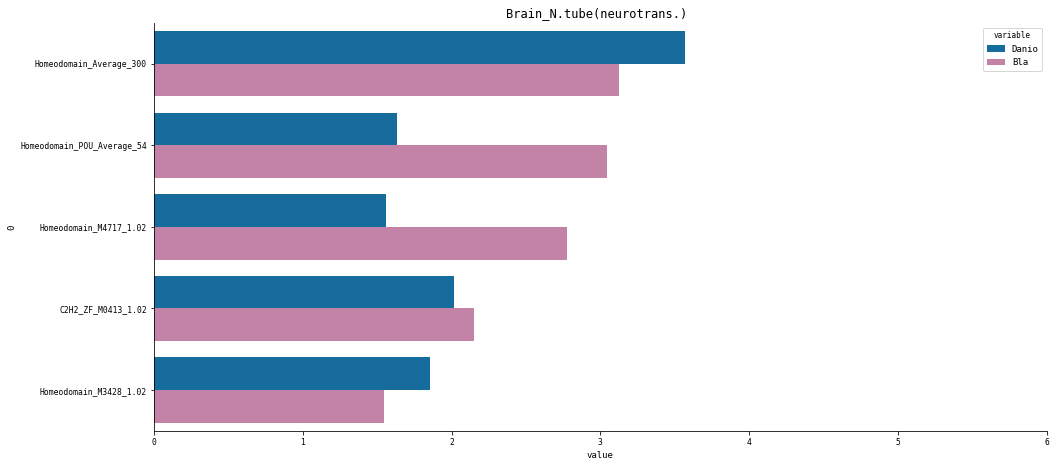

In [25]:
# Select some interesting cases and plot the RBOscore 
# for those TFs in both species:
flag=0
for drown, drow in dan_toplot.iterrows():
    for brown, brow in bla_toplot.iterrows():
        ld = drow.sort_values(ascending=False).index.values
        lb = brow.sort_values(ascending=False).index.values
        rbo = RBOscore(ld,lb, 0.85)
        if rbo >0.25:
            
            
            d = dan_toplot.loc[drown,:].sort_values(ascending=False)
            dset = set(d[d>1.5].index.values)

            b = bla_toplot.loc[brown,:].sort_values(ascending=False)
            bset = set(b[b>1.5].index.values)

            gset = dset.intersection(bset)

            gee = SF.loc[gset].drop_duplicates(subset=2).copy()

            gee['Danio'] = gee.index.to_series().map(d.loc[gset])
            gee['Bla'] = gee.index.to_series().map(b.loc[gset])


            tp = gee[[0,'Danio','Bla']]
            
            plt.figure(figsize=(16,1.5*len(gset)))
            order = tp.loc[tp.sum( axis=1)
                           .sort_values(ascending=False)
                           .index,0].values
            
            sns.barplot(data=pd.melt(tp,id_vars=0),
                        x='value',y=0, hue='variable', 
                        order=order,
                       palette={'Danio':'#0072b2',
                                'Bla':'#cc79a7'})
            
            title = "{}_{} ".format(drown, brown)
            plt.title(title)
            sns.despine()
            plt.xlim((0,6))
            
            plt.show()
            flag=1
            break 
        # use this to limit output when printing
        if flag:
            break